# Dependencies and Libraries

In [1]:
!pip install kaggle

In [2]:
!pip install tensorflow

In [3]:
from google.colab import files
import pandas as pd
import numpy as np
import re
import nltk
import json
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from sklearn.linear_model import LogisticRegression


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gzip
import shutil
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Personal Kaggle API for importing dataset from Kaggle

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshanrsurk19cs2008","key":"28c400a91751388d3c6837bcb396d080"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
!cp /content/kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

### Downloading Dataset

In [10]:
! kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 31% 8.00M/25.7M [00:00<00:00, 81.5MB/s]
100% 25.7M/25.7M [00:00<00:00, 179MB/s] 


In [11]:
!unzip "/content/imdb-dataset-of-50k-movie-reviews.zip"

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [12]:
!rm "/content/imdb-dataset-of-50k-movie-reviews.zip"

### DataFrame Name =movie_reviews

In [13]:
movie_reviews=pd.read_csv("/content/IMDB Dataset.csv")

In [14]:
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [15]:
movie_reviews.isnull().values.any()

False

### Visualizing Dataset

<ipython-input-16-27d17567fdb8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=movie_reviews, palette=colors)


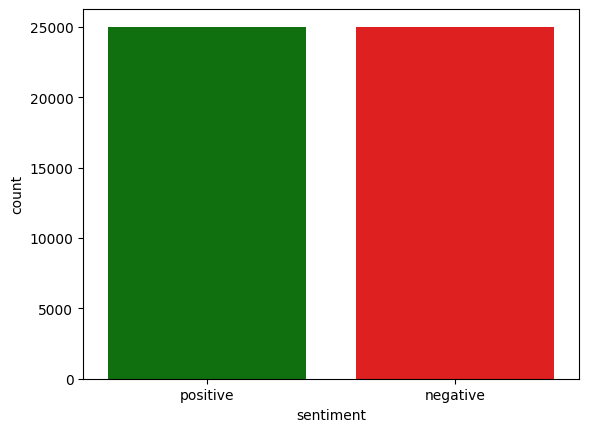

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors for each sentiment
colors = {"positive": "green", "negative": "red"}

# Create the countplot with custom colors
sns.countplot(x="sentiment", data=movie_reviews, palette=colors)

# Show the plot
plt.show()

In [17]:
movie_reviews["review"][2]


'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [18]:
sentiment_counts = movie_reviews['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Stopwords from NLTK to remove commonly used words like "the", "is", "and", etc

In [19]:
import nltk
from nltk.corpus import stopwords

In [20]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:

class TextPreprocessor:
    def __init__(self):
        # Use NLTK's predefined stopwords for English
        self.stopwords = set(stopwords.words('english'))

    def clean_html(self, text):
        html_pattern = re.compile('<.*?>')
        return html_pattern.sub('', text)

    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = self.clean_html(text)

        # Remove punctuations and numbers
        text = re.sub('[^a-zA-Z]', ' ', text)

        # Remove single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove stopwords
        words = text.split()
        filtered_words = [word for word in words if word not in self.stopwords]

        return ' '.join(filtered_words)

In [22]:
text_processor=TextPreprocessor()

In [23]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(text_processor.preprocess_text(sen))

In [44]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, movie_reviews['sentiment']))) # positive: 1, negative: 0

In [45]:
X[0]

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

In [46]:
len(X)

50000

In [47]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [55]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import matplotlib.colors as mcolors
import plotly.graph_objects as go



In [49]:
df = pd.DataFrame({'text': X, 'sentiment': y})


In [50]:
df.to_csv('file1.csv')


In [51]:

# Separate positive and negative texts
positive_texts = ' '.join(df[df['sentiment'] == 1]['text']).split()
negative_texts = ' '.join(df[df['sentiment'] == 0]['text']).split()

# Count word frequencies for each sentiment
positive_word_counts = Counter(positive_texts)
negative_word_counts = Counter(negative_texts)

# Get all unique words
all_words = set(positive_word_counts.keys()).union(set(negative_word_counts.keys()))

In [59]:
# Calculate word metrics
word_data = []
for word in all_words:
    # Skip very short words (often not meaningful)
    if len(word) < 3:
        continue

    pos_count = positive_word_counts.get(word, 0)
    neg_count = negative_word_counts.get(word, 0)
    total_count = pos_count + neg_count

    # Lower the frequency threshold to include more words
    if total_count < 5:  # Reduced from 10 to 5
        continue

    # Calculate sentiment score between -1 (negative) and 1 (positive)
    sentiment_score = (pos_count - neg_count) / total_count

    word_data.append({
        'word': word,
        'pos_count': pos_count,
        'neg_count': neg_count,
        'total_count': total_count,
        'sentiment_score': sentiment_score
    })

# Check if we have any words
if not word_data:
    raise ValueError("No words met the filtering criteria. Try reducing the minimum frequency threshold.")

# Sort by total frequency and take top words - use more words to fill the sphere
word_data.sort(key=lambda x: x['total_count'], reverse=True)
top_words = word_data[:500]  # Increased to 500 words for better coverage

print(f"Using {len(top_words)} words for visualization")

# Create balanced distribution of positive and negative words
pos_words = [w for w in word_data if w['sentiment_score'] > 0]
neg_words = [w for w in word_data if w['sentiment_score'] <= 0]

# Take equal numbers of positive and negative words if possible
max_per_category = min(250, len(pos_words), len(neg_words))
pos_words = pos_words[:max_per_category]
neg_words = neg_words[:max_per_category]

# Combine them
balanced_words = pos_words + neg_words

# Use the combined list or the original if we don't have enough words
selected_words = balanced_words if len(balanced_words) >= 100 else top_words

# Create spherical coordinates for more even distribution across the sphere
n_points = len(selected_words)

# Golden spiral algorithm for evenly distributing points on a sphere
indices = np.arange(0, n_points, dtype=float) + 0.5
phi = np.arccos(1 - 2*indices/n_points)
theta = np.pi * (1 + 5**0.5) * indices

# Adjust theta based on sentiment to cluster similar sentiment words
sentiment_values = np.array([w['sentiment_score'] for w in selected_words])
theta_adjustment = np.pi * sentiment_values / 2  # Scale to half circle
theta = theta + theta_adjustment

# Convert to Cartesian coordinates
r = 1.0  # Unit sphere
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

# Add some random variation to prevent exact overlaps
variation = 0.1
x += np.random.uniform(-variation, variation, n_points)
y += np.random.uniform(-variation, variation, n_points)
z += np.random.uniform(-variation, variation, n_points)

# Re-normalize to keep points on sphere surface
magnitudes = np.sqrt(x**2 + y**2 + z**2)
x /= magnitudes
y /= magnitudes
z /= magnitudes

# Calculate appropriate marker sizes - make all similar size
min_size = 8
max_size = 14
sizes = np.ones(n_points) * min_size
# Add slight variation based on frequency (less pronounced)
log_frequencies = np.log1p(np.array([w['total_count'] for w in selected_words]))
if len(np.unique(log_frequencies)) > 1:
    normalized_freq = (log_frequencies - log_frequencies.min()) / (log_frequencies.max() - log_frequencies.min() + 1e-10)
    sizes += normalized_freq * (max_size - min_size) * 0.5  # Reduced influence of frequency

# Create the 3D scatter plot with Plotly
fig = go.Figure()

# Add the word markers
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers+text',
    marker=dict(
        size=sizes,
        color=sentiment_values,
        colorscale='RdBu',
        colorbar=dict(
            title='Sentiment',
            titleside='right'
        ),
        opacity=0.7
    ),
    text=[w['word'] for w in selected_words],
    textposition='middle center',
    textfont=dict(
        # Use regular font (not bold)
        color='black',
        size=10,  # Fixed size for all text
        family="Arial, sans-serif"  # Regular font
    ),
    hovertemplate='<b>%{text}</b><br>Sentiment: %{marker.color:.2f}<extra></extra>'
))

# Update the layout to hide axes and make the background transparent
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False, showticklabels=False, showgrid=False, zeroline=False, showbackground=False, title=''),
        yaxis=dict(visible=False, showticklabels=False, showgrid=False, zeroline=False, showbackground=False, title=''),
        zaxis=dict(visible=False, showticklabels=False, showgrid=False, zeroline=False, showbackground=False, title=''),
        bgcolor='rgba(240,240,240,0.95)',  # Light gray background
    ),
    width=900,
    height=800,
    margin=dict(l=0, r=0, t=30, b=0),
    paper_bgcolor='rgba(255,255,255,1)',
    scene_camera=dict(
        eye=dict(x=1.8, y=1.8, z=1.2)
    ),
    title=dict(
        text='Interactive 3D Word Sphere by Sentiment',
        y=0.95
    )
)

# Show the interactive 3D visualization
fig.show()

Using 500 words for visualization
